## Load data for WA and Control States

In [154]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
pd.set_option("mode.copy_on_write", True)

data_1 = "https://github.com/MIDS-at-Duke/opioid-2023-group-8-final-opioid/raw/data_merging/20_Intermediate_Files/Washington_Merged.csv"
wa_and_control_death = pd.read_csv(data_1)

In [155]:
wa_and_control_death["Deaths"].sum()

41010.0

In [156]:
# Dropping rows where there is any NA value
wa_and_control_death_cleaned = wa_and_control_death.dropna()

In [157]:
wa_and_control_death_cleaned.head()

,Year,State Code,County,County Code,Population,Deaths,Dosage
2991,2003,OH,"Lorain County, OH",39093,290622.0,13.0,0.0
2992,2003,OH,"Lucas County, OH",39095,453778.0,19.0,0.0
2994,2003,OH,"Mahoning County, OH",39099,251696.0,14.0,0.0
3000,2003,OH,"Montgomery County, OH",39113,551742.0,52.0,0.0
3011,2003,OH,"Licking County, OH",39089,152582.0,11.0,0.0


## Death-per-capita for WA and Control States

In [158]:
# Calculating death_per_capita
wa_and_control_death_cleaned["Death_per_capita"] = (
    wa_and_control_death_cleaned["Deaths"] / wa_and_control_death_cleaned["Population"]
)

## Sort out the WA and Control States Separately

In [159]:
# subset the data for only WA
wa_treatment_state = wa_and_control_death_cleaned[
    wa_and_control_death_cleaned["State Code"] == "WA"
]
# subset the data for only the control states
controls = ["OH", "MN", "ME"]
control_states = wa_and_control_death_cleaned[
    wa_and_control_death_cleaned["State Code"].isin(controls)
]

In [160]:
wa_treatment_state.sample(5)

,Year,State Code,County,County Code,Population,Deaths,Dosage,Death_per_capita
4008,2007,WA,"Spokane County, WA",53063,456150.0,104.0,1.988135e+08,0.000228
3788,2006,WA,"Kittitas County, WA",53037,38680.0,5.0,9.093796e+06,0.000129
3801,2006,WA,"Grant County, WA",53025,81036.0,11.0,3.814272e+07,0.000136
5154,2012,WA,"Skagit County, WA",53057,117716.0,17.0,4.593327e+07,0.000144
4238,2008,WA,"Spokane County, WA",53063,462263.0,126.0,2.046712e+08,0.000273


In [161]:
control_states.sample(5)

,Year,State Code,County,County Code,Population,Deaths,Dosage,Death_per_capita
5538,2014,OH,"Pickaway County, OH",39129,56703.0,9.0,2.445922e+07,0.000159
5054,2011,MN,"Wabasha County, MN",27157,21609.0,2.0,1.942953e+06,0.000093
5422,2013,MN,"Big Stone County, MN",27011,5069.0,1.0,1.773652e+06,0.000197
3899,2006,MN,"Steele County, MN",27147,36040.0,3.0,3.036624e+06,0.000083
4112,2007,MN,"Yellow Medicine County, MN",27173,10574.0,1.0,1.163826e+06,0.000095


## Plot Diff-in-Diff

In [162]:
sub_wa_treatment_state = wa_treatment_state[
    (wa_treatment_state["Year"] >= 2003) & (wa_treatment_state["Year"] <= 2015)
]

sub_control_states = control_states[
    (control_states["Year"] >= 2003) & (control_states["Year"] <= 2015)
]

In [163]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn.objects as so
from matplotlib.lines import Line2D

# specify the years needed before the policy change
year = [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]
# create new dataframe with only data from those years
pre_WA_death = sub_wa_treatment_state.loc[sub_wa_treatment_state["Year"].isin(year)]
post_WA_death = sub_wa_treatment_state.loc[~sub_wa_treatment_state["Year"].isin(year)]

pre_crtl_death = sub_control_states.loc[sub_control_states["Year"].isin(year)]
post_crtl_death = sub_control_states.loc[~sub_control_states["Year"].isin(year)]

In [164]:
import numpy as np
import statsmodels.formula.api as smf


def get_reg_fit(data, color, yvar, xvar, legend, alpha=0.05):
    years = list(np.arange(2003, 2015, 1))

    # Grid for predicted values
    x = data.loc[pd.notnull(data[yvar]), xvar]
    xmin = x.min()
    xmax = x.max()
    step = (xmax - xmin) / 100
    grid = np.arange(xmin, xmax + step, step)
    predictions = pd.DataFrame({xvar: grid})

    # Fit model, get predictions
    model = smf.ols(f"{yvar} ~ {xvar}", data=data).fit()
    model_predict = model.get_prediction(predictions[xvar])
    predictions[yvar] = model_predict.summary_frame()["mean"]
    predictions[["ci_low", "ci_high"]] = model_predict.conf_int(alpha=alpha)

    # Build chart
    predictions["Treat"] = f"{legend}"

    # Plotting regression line
    plt.plot(predictions[xvar], predictions[yvar], color=color, label=legend)

    # Plotting confidence interval
    plt.fill_between(
        predictions[xvar],
        predictions["ci_low"],
        predictions["ci_high"],
        color=color,
        alpha=0.3,
        label=f"{legend} CI",
    )

    plt.xlabel(xvar)
    plt.ylabel("Death per Capita")

    return predictions

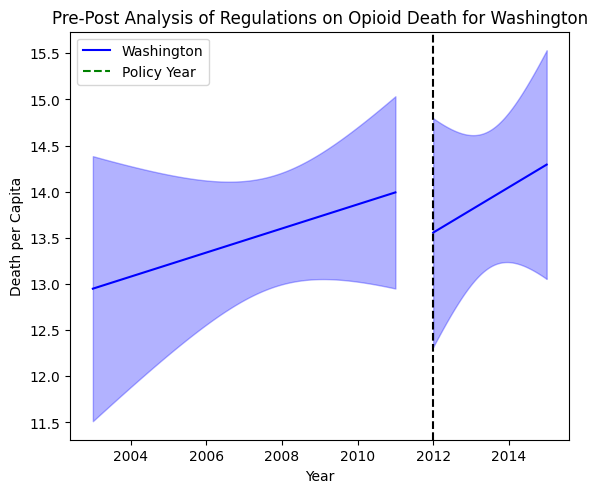

In [165]:
# Create subplots
fig, ax = plt.subplots()

# Scale up the 'Death_per_capita' values by multiplying by 100000
pre_WA_death["Death_per_capita_scaled"] = pre_WA_death["Death_per_capita"] * 100000
post_WA_death["Death_per_capita_scaled"] = post_WA_death["Death_per_capita"] * 100000

# Plot pre_WA_plot
pre_WA_plot = get_reg_fit(
    pre_WA_death, "blue", "Death_per_capita_scaled", "Year", "Washington", alpha=0.05
)

# Plot post_WA_plot
post_WA_plot = get_reg_fit(
    post_WA_death, "blue", "Death_per_capita_scaled", "Year", "Washington", alpha=0.05
)

# Plotting a vertical line for the policy year
ax.axvline(x=2012, color="black", linestyle="--", label="Policy Year")

plt.title("Pre-Post Analysis of Regulations on Opioid Death for Washington")

plt.legend(
    handles=[
        Line2D([0], [0], color="blue", label="Washington"),
        Line2D([0], [0], color="green", linestyle="--", label="Policy Year"),
    ],
    loc="upper left",
)

# Show the plot
plt.subplots_adjust(left=0.17, right=0.95, top=0.95, bottom=0.1)
plt.savefig("PrePostDeathWashington.png", format="png")
plt.show()

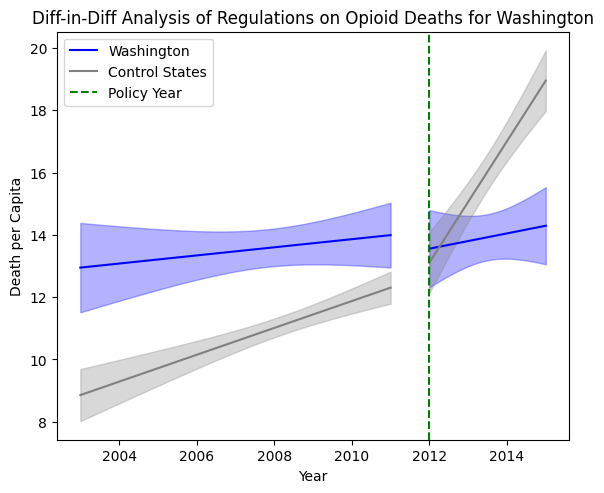

In [166]:
# Plot all data on the same chart
fig, ax = plt.subplots()

# Plot pre_WA_plot

pre_WA_plot = get_reg_fit(
    pre_WA_death, "blue", "Death_per_capita_scaled", "Year", "Washington", alpha=0.05
)

# Plot post_WA_plot
post_WA_plot = get_reg_fit(
    post_WA_death, "blue", "Death_per_capita_scaled", "Year", "Washington", alpha=0.05
)

# Ensure the same scaling is applied to the control states dataframes
pre_crtl_death["Death_per_capita_scaled"] = pre_crtl_death["Death_per_capita"] * 100000
post_crtl_death["Death_per_capita_scaled"] = (
    post_crtl_death["Death_per_capita"] * 100000
)

# Plot pre_crtl_plot
pre_crtl_plot = get_reg_fit(
    pre_crtl_death,
    "grey",
    "Death_per_capita_scaled",
    "Year",
    "Control States",
    alpha=0.05,
)

# Plot post_crtl_plot
post_crtl_plot = get_reg_fit(
    post_crtl_death,
    "grey",
    "Death_per_capita_scaled",
    "Year",
    "Control States",
    alpha=0.05,
)

# Plotting a vertical line for the policy year
ax.axvline(x=2012, color="green", linestyle="--", label="Policy Year")

# Set chart title
plt.title("Diff-in-Diff Analysis of Regulations on Opioid Deaths for Washington")

# Display the legend with more specific labels
plt.legend(
    handles=[
        Line2D([0], [0], color="blue", label="Washington"),
        Line2D([0], [0], color="grey", label="Control States"),
        Line2D([0], [0], color="green", linestyle="--", label="Policy Year"),
    ],
    loc="upper left",
)

# Show the plot
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.1)
plt.savefig("DiffDeathWashington.png", format="png")
plt.show()